# MSDS 7331 - Case Study 3 - Clasification of e-mail as ham or spam
Daniel Crouthamel

Sophia Wu

Fabio Savorgnan

Bo Yun

# Introduction

In this study, we will be building a classifier to predict email that are spam or ham. 

# Business Understanding

The business is receiving multiples emails that are spam. This causes that the member of the business miss important email because the member erase multiples e mail that are spam and among those the member erase ham email which can be important.

An internal IT department has raised an alarm that the staff is receiving a large amount of spam email. They have requested the rock star data scicence team at SMU to build a solution that not only minimizes the number of spam emails, but also keeps important emails from getting flagged as spam and missed.

With that in mind, Precision will be and important classification metric to use in our analysis.

Our team will build a Naive Bayes model for classification, and leverage the insights from EDA to incorporate clustering as part of the model features. 

# Data Evaluation / Engineering

In [1]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#NB
from sklearn.pipeline import make_pipeline


# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import email
import email.parser
from email.parser import Parser

#NLP
import nltk
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        ##chdir('/Users/fabiosavorgnan/Desktop/QTW/Week_1/Data/MSDS-7333-QTW')
        chdir('/Users/boyun/Desktop/SMU/DS7333-QuantifyingTheWorld/MSDS-7333-QTW/')
        # chdir('D:\Projects\MSDS-7333-QTW')

    active_dir = getcwd()
       
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
            ] 
    
    res_frame = pd.DataFrame()

    # *dc - Added to keep a collection of email text
    emails = []

    bodies = []
        
    for d in directories:
        mypath = getcwd() + '/data/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
            
            with open(mypath + file, encoding='latin1') as f:
                body = f.read()
                f.close()
                
            msg = email.message_from_string(str(body))
            tmpStr = ''
            
            if msg.is_multipart():
                for payload in msg.get_payload():
                    #tmp.append(str(payload.get_payload()))
                    
                    tmpStr = ' '.join(str(payload.get_payload()))
                bodies.append(tmpStr)
            else:
                bodies.append(str(msg.get_payload()))
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            for line in lines:

                n_lines += 1
                if "Subject: Re: " in line:
                   in_reply_count += 1
                if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
                if "content-type: multipart" in line.lower():
                   attachments += 1
                if line == "\n":
                   blank_lines.append(n_lines)
        
            temp_frame = pd.DataFrame({
                        'directory':d,    
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'in_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'],
                        ## *dc+3 
                        #'body_lines': n_lines - min(blank_lines)
                        'body_lines': [0 if len(blank_lines) == 0 else min(blank_lines)]
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)

            ## *dc+2
            #append body of email to collection
            text = ' '.join(lines)
            emails.append(text)
            
    #res_frame.to_csv('output_file.csv', index=False)
    
    ## *dc - add emails
    return res_frame, emails, bodies

df, emails, bodies = main()

Above we loaded the data set provided to us, along with creating data sets that represent the entire file (emails) and the body of the email (bodies). To pull the body of the email we used an EmailParser libary. We'll use this information later during clustering.

Below we do a quick data set summary, outputing our features, names and a few sampled rows. We created the directory attribute, in case it comes in handy. There are no missing values in the data set. There is only one numberic feature, the number of lines in the email, along 3 categorical features and 1 target feature. For modeling later, filename and directory will be removed.

In [3]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   directory    9353 non-null   object
 1   filename     9353 non-null   object
 2   is_spam      9353 non-null   object
 3   in_reply     9353 non-null   object
 4   subj_caps    9353 non-null   object
 5   attachments  9353 non-null   object
 6   body_lines   9353 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 511.6+ KB


,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines
3651,easy_ham,00187.f2e1e617b73fa1c5137d78383372886f,N,N,N,N,46
5870,easy_ham_2,01163.ce66ad7634e93c6c76e449b74f5139c4,N,Y,N,N,50
5320,easy_ham_2,01325.d94c9e1cca235f9f1bcecf469954490f,N,N,N,Y,83
2531,easy_ham,00630.d4dad4b8734a30afbf8c80499e652c2c,N,Y,N,N,44
3036,easy_ham,1552.397ac9c4693e0e39de3c115fe7ded51f,N,Y,N,N,71


Below we will replace the 'Y' and 'N' values with 1 and 0, respectively.

In [4]:
df = df.replace(['Y','N'],[1,0])
df.sample(5)

,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines
2697,easy_ham,0726.b9cf1bbdedddc254ac0a78e9fdb22a8e,0,1,0,0,46
4564,easy_ham,01537.ded3233d7649ef141c30e4cc1349f790,0,1,0,0,33
4471,easy_ham,0966.20a99be33fcc43b63c8b082d9348ee02,0,0,0,0,54
9127,spam_2,00010.2558d935f6439cb40d3acb8b8569aa9b,1,0,0,0,56
1987,easy_ham,00936.e8fd8c240b680e948f85f2326cc87250,0,0,0,0,45


Below we lift some code I (Dan) used in a recent NLP class. Here we use nltk to remove stop words, etc, from the bodies in our emails. This will be used in our EDA and modeling later.

In [5]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and remove special characters to form a normalized document
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = nltk.word_tokenize(doc)
    
    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]

    # stem tokens - Skipping for now
    #filtered_tokens = [stemming.stem(token) for token in filtered_tokens]

    # re-create a normalized document
    doc = ' '.join(filtered_tokens)
    return doc

normalize_text = np.vectorize(normalize_document)
norm_text = normalize_text(emails)

print(type(norm_text),len(norm_text))

<class 'numpy.ndarray'> 9353


## Using processed norm_text and directory to convert it to a dataframe

In [6]:
norm_text_2 = pd.DataFrame(norm_text)
directory = pd.DataFrame(df['directory'])
combined_df = pd.concat([norm_text_2,directory],axis=1)
combined_df.columns = ['text','directory']
combined_df['text'] = combined_df['text'].apply(lambda x: x.split())
combined_df

,text,directory
0,"[rssfeeds, jmason, org, mon, sep, return, path...",easy_ham
1,"[fork, admin, xent, com, tue, sep, return, pat...",easy_ham
2,"[fork, admin, xent, com, tue, sep, return, pat...",easy_ham
3,"[rpm, list, admin, freshrpms, net, mon, sep, r...",easy_ham
4,"[secprog, return, jmason, org, securityfocus, ...",easy_ham
...,...,...
9348,"[687ifsuy, bol, com, tue, aug, return, path, 6...",spam_2
9349,"[mraimecoilcipc, msn, com, mon, jul, return, p...",spam_2
9350,"[fork, admin, xent, com, thu, aug, return, pat...",spam_2
9351,"[niddeel, hotmail, com, tue, aug, return, path...",spam_2


# Data engineering

Feature Set:

1-	we will create a variable which states the replay or not replay (n_reply_count)

2-	we will create a variable which states if all the subject lines are capital or not (sub_line_all_caps).

3-	we will create a variable which states if the email has attachment or not (attachments).

4-	we will create a variable which states the number of lines in the subject (subject_line).

5-	we will create a variable which states the number of lines if it is more than 0 (n_lines) in the e mail.

6-	we will create a variable which states the number of black lines in the email (blank_lines).

7-	We will extract the body from the email, then we will run the TDIDF in the body; furthermore , we will run a k-mean  to cluster the TDIDF that we extracted from the body.

We will calculate the bag of words. A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms. The approach is very simple and flexible and can be used in a myriad of ways for extracting features from documents. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

	A vocabulary of known words.
	A measure of the presence of known words.

It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

It has many uses, most importantly in automated text analysis, and is very useful for scoring words in machine learning algorithms for Natural Language Processing (NLP).

TF-IDF was invented for document search and information retrieval. It works by increasing proportionally to the number of times a word appears in a document but is offset by the number of documents that contain the word. So, words that are common in every document, such as this, what, and if, rank low even though they may appear many times, since they don’t mean much to that document in particular.

However, if the word Bug appears many times in a document, while not appearing many times in others, it probably means that it’s very relevant. For example, if what we’re doing is trying to find out which topics some NPS responses belong to, the word Bug would probably end up being tied to the topic Reliability, since most responses containing that word would be about that topic.

The code below is used to create a TfIDF matrix that will be used later in clustering. In this case, we arbitarly chose grams up to 3 words, shoudl appear in at least 5 emails, and at in no more than 80% of all emails.

In [7]:
tf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=.8, stop_words=stop_words, norm='l2')
tf_matrix = tf.fit_transform(norm_text)

print(tf_matrix.shape)

(9353, 166742)


## EDA
### `Latent Dirichlet Allocation (LDA) Topic Modeling`
- Topic modeling using LDA will be utilized for the EDA to extract main topics of the given email content and see how certain lemmatized texts correlate with each email directory. 
- LDA is a type of statistical modeling used to classify text in a document to a particular topic. Dirichlet distribution is used here to calculate a topic per document model and words per topic model. 
- Due to the newest version of Gensim package removing one of key LDA wrappers, Mallet's LDA result cannot be transferred to a Gensim model for PCA visualization. Gensim will be separately modeled and the results will be compared against Mallet's version to verify both results and enhance the insights.

### Training Mallet's topic model

In [8]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import little_mallet_wrapper as lmw

combined_df['text_2'] = combined_df['text'].apply(lambda x: ' '.join(x))

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

path_to_mallet = "/Users/boyun/Desktop/SMU/DS7333-QuantifyingTheWorld/CaseStudy_Bo/CS3/mallet-2.0.8/bin/mallet" # update this path
# path_to_mallet = "D:/Projects/MSDS-7333-QTW/mallet-2.0.8/bin/mallet" # update this path

training_data = [lmw.process_string(t) for t in combined_df['text_2']]
training_data = [d for d in training_data if d.strip()]


# Number of topics that user specifies
num_topics = 15  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS

# output_directory_path = 'D:/Projects/MSDS-7333-QTW' # CHANGE THIS TO YOUR OUTPUT DIRECTORY
output_directory_path = '/Users/boyun/Desktop/SMU/DS7333-QuantifyingTheWorld/CaseStudy_Bo/CS3' # CHANGE THIS TO YOUR OUTPUT DIRECTORY

topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_data)

Importing data...
Complete
Training topic model...
Complete


In [9]:
assert(len(topic_distributions) == len(training_data))

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 NUMd font NUM size face color NUMdNUM nbsp width align
1 	 NUM net sourceforge com spamassassin example users exmh list received
2 	 NUM width http height src img gif font www border
3 	 NUM money blockquote business people government mail free report states
4 	 com received net localhost org netnoteinc http esmtp content zzzz
5 	 NUM NUMe net NUMc pro ssz cypherpunks jul iiu minder
6 	 org localhost oct com received dogma slashnull jmason http taint
7 	 com xent fork NUM localhost list received org sep mailto
8 	 font NUM http www com size href color verdana table
9 	 com bNUM dNUM yahoo aNUM cNUM NUM yahoogroups zzzzteana received
10 	 one would com like people time net get could date
11 	 NUM http code securityfocus com software java web xml www
12 	 http www nbsp href com lockergnome html font NUM table
13 	 linux ilug NUM org localhost received lugh aug tuatha com
14 	 net NUM freshrpms rpm list zzzlist egwn localhost received http


In [10]:
# Organizing the result into a dictionary

topic_word_probability_dict = lmw.load_topic_word_distributions(output_directory_path + '/mallet.word_weights.' + str(num_topics))
len(topic_word_probability_dict)

15

#### Each topic and its weight distribution of words 

In [11]:
for _topic, _word_probability_dict in topic_word_probability_dict.items():
    print('Topic', _topic)
    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(round(_probability, 4), '\t', _word)
    print()

Topic 0
0.1403 	 NUMd
0.0904 	 font
0.0521 	 NUM
0.0336 	 size
0.0243 	 face
0.0237 	 color
0.0226 	 NUMdNUM
0.0211 	 nbsp
0.0209 	 width
0.0176 	 align
0.0147 	 arial
0.0122 	 center
0.0111 	 table
0.0096 	 height
0.0092 	 http

Topic 1
0.0817 	 NUM
0.0354 	 net
0.0329 	 sourceforge
0.0301 	 com
0.0246 	 spamassassin
0.0216 	 example
0.021 	 users
0.0199 	 exmh
0.0184 	 list
0.0172 	 received
0.0158 	 org
0.0148 	 localhost
0.0118 	 talk
0.0116 	 razor
0.0113 	 aug

Topic 2
0.0986 	 NUM
0.0626 	 width
0.0554 	 http
0.038 	 height
0.0377 	 src
0.037 	 img
0.0356 	 gif
0.0303 	 font
0.0271 	 www
0.0238 	 border
0.0221 	 cnet
0.0184 	 href
0.0172 	 bgcolor
0.0172 	 com/b
0.0166 	 table

Topic 3
0.0233 	 NUM
0.0075 	 money
0.0073 	 blockquote
0.0069 	 business
0.0057 	 people
0.005 	 government
0.0048 	 mail
0.0046 	 free
0.0043 	 report
0.0038 	 states
0.0037 	 make
0.0036 	 new
0.0035 	 order
0.0035 	 send
0.0034 	 one

Topic 4
0.0671 	 com
0.0237 	 received
0.0217 	 net
0.0199 	 localh

#### `Results from the heatmap and box and whisker plots below suggest that __Topic 0, 3 and 4 are highly correlated with 'Spam'__ directory and __Topic 0, 3, 4, and 5 are highly correlated with 'Spam_2'__ directory. This shows the correlation of certain words with directories and address the need to include clustering of lemmatized texts as a feature in the prediction model.`

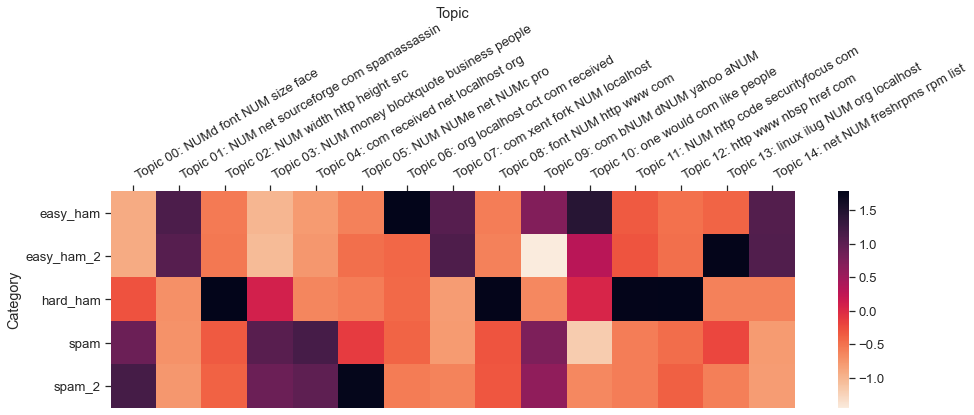

In [12]:
directory = combined_df['directory'].tolist()

target_labels = ["easy_ham", "easy_ham_2", "hard_ham", "spam", "spam_2"]

lmw.plot_categories_by_topics_heatmap(directory,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(14,6))

In [17]:
print('Spam directory is related to the following topics : \n', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[0,0],'\t', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[3,0],'\t', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[4,0])
print('\n','Spam_2 directory is related to the following topics : \n', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[0,0],'\n',pd.DataFrame([','.join(i) for i in topic_keys]).iloc[5,0])

Spam directory is related to the following topics : 
 NUMd,font,NUM,size,face,color,NUMdNUM,nbsp,width,align,arial,center,table,height,http,div,style,helvetica,verdana,serif 	 NUM,money,blockquote,business,people,government,mail,free,report,states,make,new,order,send,one,name,million,company,address,united 	 com,received,net,localhost,org,netnoteinc,http,esmtp,content,zzzz,aug,mail,jul,subject,mon,NUM,html,smtp,sep,free

 Spam_2 directory is related to the following topics : 
 NUMd,font,NUM,size,face,color,NUMdNUM,nbsp,width,align,arial,center,table,height,http,div,style,helvetica,verdana,serif 
 NUM,NUMe,net,NUMc,pro,ssz,cypherpunks,jul,iiu,minder,cpunks,einstein,NUMffont,NUMcfont,sightings,NUMb,locust,waste,envelope,received


/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


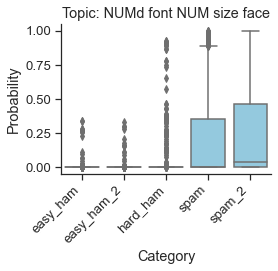

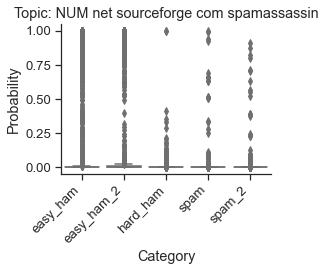

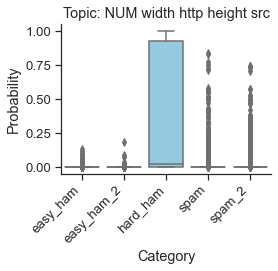

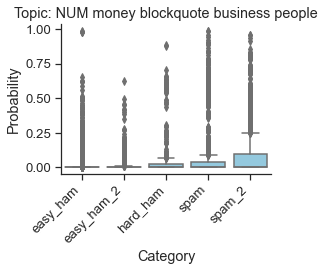

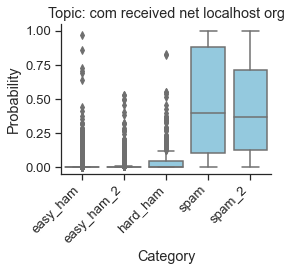

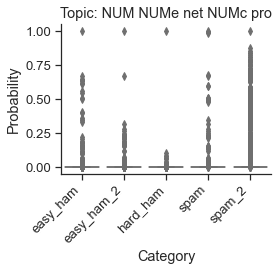

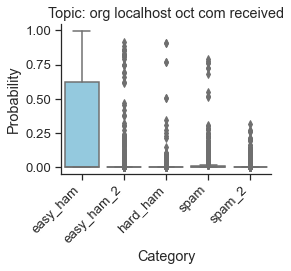

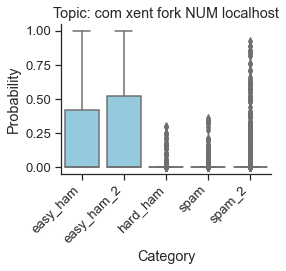

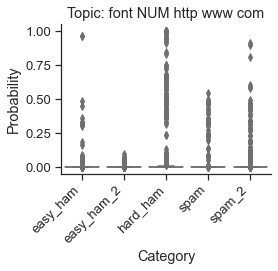

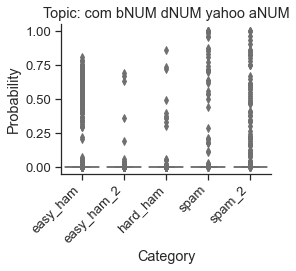

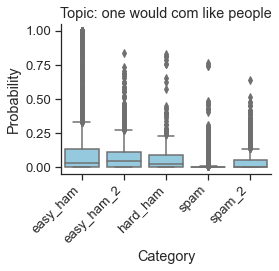

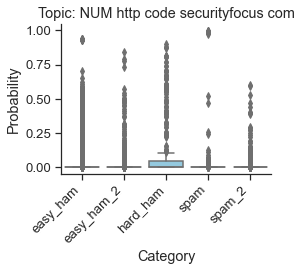

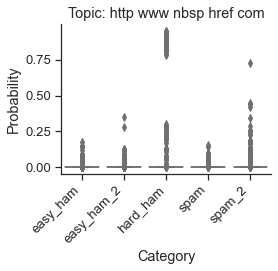

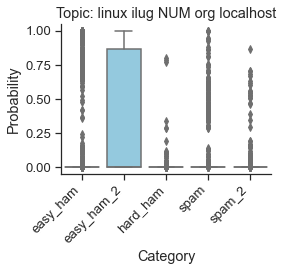

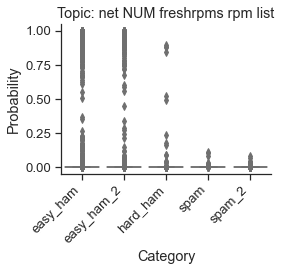

In [14]:
target_labels = ["easy_ham", "easy_ham_2", "hard_ham", "spam", "spam_2"]

for _topic_index in range(0, len(topic_keys)):
    
    lmw.plot_categories_by_topic_boxplots(directory,
                                          topic_distributions,
                                          topic_keys, 
                                          _topic_index,
                                          output_path=output_directory_path + '/boxplot.' + str(_topic_index) + '.pdf',
                                          target_labels=target_labels,
                                          dim=(4,4))

### PCA plot using Gensim package

From the Mallet's LDA model, it is observed that __topic 0,3,4 and 5__ make up the the spam emails. 
From the Gensim's interactive PCA plot below, __topic 1,5,7 and 9__ are clustered in the same region, which indicate there is a clear pattern on what topics/words dictate spam directory.  It also appears that words belonging to clusters of __topic 1,5,7 and 9__ are very similar to the __topic 0,3,4 and 5__ of Mallet's model. Thus we can conclude that those clusters make up the spam directories. 
Below are some of the observed characteristics of topics from the spam directory. 

- Topic 1 from the PCA plot below mainly talk about font sizes, styles of the email using words such as "font","width","color","verdana". 
- Topic 5 talks about sending money to a certain address using words such as "send", "free", "money", "address", "investment", "services"
- As seen in the PCA plot below, the overall term frequencies of the words in Topic 1 and 5 are very low, meaning they are very specific to each individual topic. This tells that these words are very unique in spam directories and can be used as features for modeling. 
- Looking at the shape of the PCA plot, the number of clusters could be reduced down to 3 for further research. 

In [15]:
import gensim
from gensim.corpora import Dictionary
import pickle
import pandas as pd
import pyLDAvis
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from pprint import pprint
import spacy
import re 
import pyLDAvis
import matplotlib.pyplot as plt 
import pandas as pd
import gensim.corpora as corpora

# Create Dictionary
dictionary = corpora.Dictionary(combined_df['text'])

# Create Corpus
texts = combined_df['text']

# Term Document Frequency
doc_term_matrix = [dictionary.doc2bow(text) for text in texts]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=15, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()

/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


[(0,
  '0.096*"http" + 0.013*"web" + 0.010*"software" + 0.010*"site" + 0.007*"windows" + 0.006*"url" + 0.006*"internet" + 0.005*"news" + 0.005*"file" + 0.004*"..."'),
 (1,
  '0.011*"business" + 0.009*"blockquote" + 0.009*"/blockquote" + 0.007*"company" + 0.007*"government" + 0.007*"money" + 0.005*"security" + 0.005*"information" + 0.005*"grants" + 0.005*"new"'),
 (2,
  '0.036*"com" + 0.026*"exmh" + 0.024*"received" + 0.020*"org" + 0.020*"redhat" + 0.020*"localhost" + 0.018*"listman" + 0.017*"mx1" + 0.014*"taint" + 0.014*"spamassassin"'),
 (3,
  '0.057*"font" + 0.053*"/font" + 0.049*"http" + 0.044*"/td" + 0.031*"nbsp" + 0.026*"img" + 0.024*"/tr" + 0.024*"width=" + 0.020*"arial" + 0.020*"href="'),
 (4,
  '0.028*"net" + 0.027*"linux" + 0.027*"localhost" + 0.024*"received" + 0.023*"ilug" + 0.022*"org" + 0.017*"esmtp" + 0.016*"lugh" + 0.015*"aug" + 0.014*"rpm"'),
 (5,
  '0.030*"zoo" + 0.030*"petting" + 0.028*"net" + 0.017*"0xdeadbeef" + 0.013*"cache" + 0.009*"bulletin" + 0.008*"gentle" + 0.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.054327 -0.266001       1        1  22.999359
13     0.236237  0.108736       2        1  12.349814
6      0.216072 -0.006306       3        1  11.366935
4      0.221381  0.099358       4        1   9.967681
14     0.068512 -0.237734       5        1   8.867432
12     0.198047  0.122532       6        1   7.409811
1     -0.019707 -0.267274       7        1   6.970847
10     0.191727  0.138039       8        1   6.955666
0     -0.004467 -0.200983       9        1   5.612169
2      0.148325  0.153306      10        1   4.340695
11    -0.228310  0.034375      11        1   1.162298
9     -0.278319  0.058295      12        1   0.751735
7     -0.239746  0.072394      13        1   0.516939
8     -0.288558  0.083844      14        1   0.445193
5     -0.275521  0.107420      15        1   0.283425, topic_info=              Term          Freq         Total Category  logprob  loglift
26            http  89586.000000  89586.000000  Default  30.0000  30.0000
3136          font  54670.000000  54670.000000  Default  29.0000  29.0000
13667        /font  50294.000000  50294.000000  Default  28.0000  28.0000
7              com  92429.000000  92429.000000  Default  27.0000  27.0000
275            net  45666.000000  45666.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
9745       chinese     24.211231    117.998437  Topic15  -6.1831   4.2821
242           list     53.294453  17434.919379  Topic15  -5.3941   0.0756
19321       bottle     25.579236    217.545614  Topic15  -6.1282   3.7254
542      subscribe     26.821543   1758.156159  Topic15  -6.0808   1.6832
771    unsubscribe     26.644350   2205.735568  Topic15  -6.0874   1.4497

[947 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
23902     15  0.922857        +ok
23911     15  0.922857     -sarun
565        1  0.028281        ...
565        2  0.157864        ...
565        3  0.092034        ...
...      ...       ...        ...
2212       3  0.707951       zzzz
2212       4  0.143854       zzzz
2212       6  0.105582       zzzz
2212      10  0.009680       zzzz
2582       3  0.998146  zzzzteana

[2294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 14, 7, 5, 15, 13, 2, 11, 1, 3, 12, 10, 8, 9, 6])

### Clustering

Below we attempt to use clustering on our data set to see if we can find any patterns in the data.

In [7]:

NUM_CLUSTERS = 15
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=10, random_state=42).fit(tf_matrix)
km

df['kmeans_cluster'] = km.labels_

email_clusters = (df[['directory', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))  # top 20 movies for each cluster
email_clusters = email_clusters.copy(deep=True)

feature_names = tf.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

# get key features for each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    print('CLUSTER #'+str(cluster_num+1), ":", cluster_silhouette_values.mean())
    print('Cluster Size', cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('-'*80)

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CLUSTER #1 : 0.08418295404425712
Cluster Size 689
Key Features: ['oct', 'rssfeeds', 'tue oct', 'oct ist received', 'oct ist', 'tue', 'example com', 'spamassassin taint org', 'spamassassin taint', 'taint org', 'taint', 'example', 'rssfeeds spamassassin', 'rssfeeds spamassassin taint', 'jmason org']
--------------------------------------------------------------------------------
CLUSTER #2 : 0.3515590026855842
Cluster Size 658
Key Features: ['rpm', 'freshrpms', 'freshrpms net', 'zzzlist', 'rpm zzzlist', 'net', 'rpm list', 'egwn', 'list', 'egwn net', 'zzzlist freshrpms', 'zzzlist freshrpms net', 'rpm zzzlist freshrpms', 'http lists freshrpms', 'lists freshrpms']
--------------------------------------------------------------------------------
CLUSTER #3 : 0.05249950816939316
Cluster Size 715
Key Features: ['font', 'width', 'td', 'size', 'nbsp', 'height', 'href http', 'src http', 'face', 'color', 'href', 'border', 'img', 'src', 'font face']
--------------------------------------------------

#### Output a quick pivot table to see distribution of clusters vs spam/ham

Below we do see an interesting case where no clusters have spam, but those do have spam also have a fair amount of non-spam emails as well, with the excpetion of cluster 10.

In [8]:
df.pivot_table(index='kmeans_cluster', columns='is_spam', values='directory', aggfunc='count')

is_spam,0,1
kmeans_cluster,,
0,689.0,NaN
1,658.0,NaN
2,257.0,458.0
3,211.0,34.0
4,691.0,108.0
5,203.0,NaN
6,295.0,NaN
7,830.0,1319.0
8,453.0,19.0


#### Elbow to find the best k number

Below we do an elbow plot to find the best k number for k-means clustering, confirming our value of 15 above. No need to run the code again below, output is already saved.

In [ ]:
scores = []

for k in range(1, 20):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(tf_matrix)
    scores.append(kmeans.inertia_)

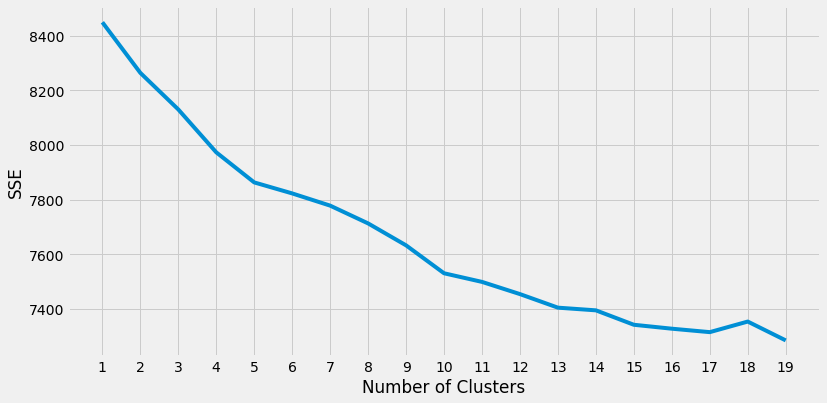

In [14]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
plt.plot(range(1, 20), scores)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Model Building and Evaluation
Below we will build two Naive Bayes Classifier models, one with and another without the clusters as features. We use the standard sklearn pipeline approach. Although we do have an inbalanced set, we decided to leave SMOTE out and see how our model performs on the data itself.

In [17]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

categorical_features = ['in_reply','subj_caps','attachments']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
#                                 #['smote', SMOTE(random_state=11)],
#                                 ['classifier', MultinomialNB()]])

clfPipeline = Pipeline(steps = [['preprocessor', preprocessor],['classifier', MultinomialNB()]])


clfPipeline.fit(X_train, y_train)

y_pred = clfPipeline.predict(X_test)

print("Accurracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))

Accurracy: 0.7792624265098878
Recall: 0.20625
Precision: 0.7557251908396947
F1 0.32405891980360063


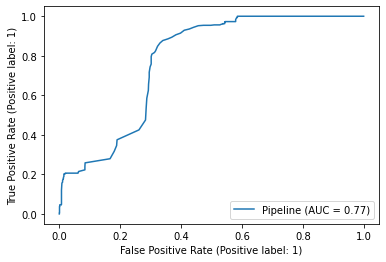

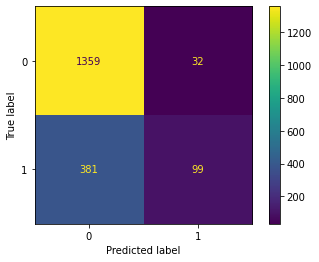

In [18]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

disp = RocCurveDisplay.from_estimator(clfPipeline, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(clfPipeline, X_test, y_test)

The above results aren't too bad with respect to precision. However, recall is quite low. This means we will show a lot of spam in our inbox, which our clients do not want.

Let's create another model but this time use the cluster we created previously to see if it can improve our model.

In [19]:
categorical_features = ['in_reply','subj_caps','attachments','kmeans_cluster']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
#                                 #['smote', SMOTE(random_state=11)],
#                                 ['classifier', MultinomialNB()]])


clfPipeline = Pipeline(steps = [['preprocessor', preprocessor],['classifier', MultinomialNB()]])


clfPipeline.fit(X_train, y_train)

y_pred = clfPipeline.predict(X_test)

print("Accurracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))

Accurracy: 0.8792089791555318
Recall: 0.9083333333333333
Precision: 0.7055016181229773
F1 0.7941712204007285


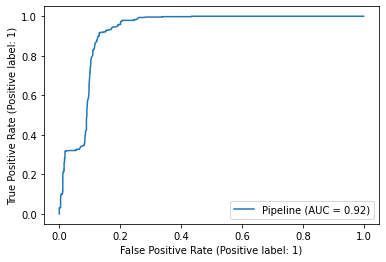

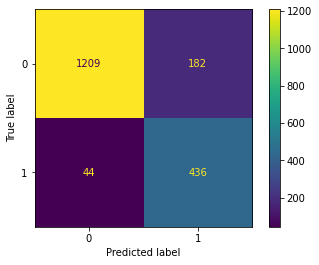

In [12]:
disp = RocCurveDisplay.from_estimator(clfPipeline, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(clfPipeline, X_test, y_test)

As can be seen above, or model as greatly improved!

# Modeling Interpretability and Explainability

Above we show 4 different metrics for each model. Which is more imporant here? The model that doesn't use the K-means feature as a feature has a higher precision, but with also a much lower recall. If we include the cluster as a feature, the precision takes a small hit, but the recall is much higher, meaning we won't be showing so many spam emails in our inbox. The F1 score with the cluster as a feature is also much higher, indicating a more balanced model with respect to precision and recall.

# Case Conclusions

Our recommendation is leverag the clustering found using NLP analysis on our emails to provide a more balanced prediction model. It provides a relatively high accuracy of 70% while maintaining a recall of near 90%